# API Keys

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

# Streaming

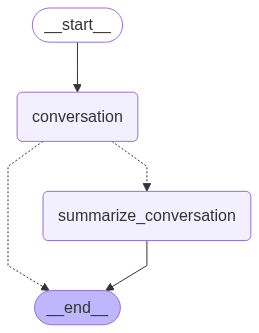

In [4]:
from IPython.display import Image, display

from typing import Literal

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import RemoveMessage
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

# LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# State
class State(MessagesState):
    summary: str

# Nodes
def call_model(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]

    return {"messages": llm.invoke(messages)}

def summarize_conversation(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the onversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    new_summary = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=message.id) for message in state["messages"]]

    return {"summary": new_summary, "messages": delete_messages}

# Condicions
def is_message_too_long(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

# Build graph
builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# Logic
builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", is_message_too_long)
builder.add_edge("summarize_conversation", END)

# Add
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming full state

In [ ]:
from random import random

config = {"configurable": {"thread_id": random()}}

input_messages = [HumanMessage(content="Hi! I'm Lance.")]

# Update state
for chunk in graph.stream({"messages": input_messages}, config=config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Lance! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--fdb7648b-5ee3-43fd-81f0-b7456421a389-0', usage_metadata={'input_tokens': 8, 'output_tokens': 390, 'total_tokens': 398, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 375}})}}


In [ ]:
for chunk in graph.stream({"messages": input_messages}, config=config, stream_mode="updates"):
    chunk['conversation']['messages'].pretty_print()

================================== Ai Message ==================================

Hi Lance! Good to connect with you again. What can I help you with today?


In [ ]:
config = {"configurable": {"thread_id": random()}}

# Full state
for event in graph.stream({"messages": input_messages}, config=config, stream_mode="values"):
    for message in event['messages']:
        message.pretty_print()
    print("---"*13 + "New value" + "---"*13 + "\n\n")

================================ Human Message =================================

Hi! I'm Lance.
---------------------------------------New value---------------------------------------


================================ Human Message =================================

Hi! I'm Lance.
================================== Ai Message ==================================

Hi Lance! Nice to meet you.

How can I help you today?
---------------------------------------New value---------------------------------------




## Streaming Tokens

In [13]:
config = {"configurable": {"thread_id": random()}}

input_messages = [HumanMessage(content="Tell me about the 49ers NFL team.")]

async for event in graph.astream_events({"messages": input_messages}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream.

In [14]:
config = {"configurable": {"thread_id": random()}}

node_to_stream = 'conversation'

async for event in graph.astream_events({"messages": input_messages}, config=config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data'])

{'chunk': AIMessageChunk(content="The **San Francisco 49ers** are one of the most storied and successful franchises in National Football League (NFL) history. Here's a comprehensive", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--a62b9040-7bba-4ccf-89c8-462fa9a94653', usage_metadata={'input_tokens': 12, 'output_tokens': 1441, 'total_tokens': 1453, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1409}})}
{'chunk': AIMessageChunk(content=' look at the team:\n\n**1. Name & Origin:**\n*   **San Francisco 49ers:** The name "49ers" comes from the prospectors who arrived in Northern California during the 1849', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--a62b9040-7bba-4ccf-89c8-462fa9a94653', usage_metadata={'output_token_details': {'reasoning': 0}, 'output_tokens': 48, 'total_tokens': 48, 'input_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=" Gold Rush.\n*   **Lo

In [17]:
config = {"configurable": {"thread_id": random()}}

async for event in graph.astream_events({"messages": input_messages}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get("langgraph_node", "") == node_to_stream:
        print(event["data"]["chunk"].content, end="\033[31m|\033[0m")

The San Francisco 49ers are one of the most storied and successful franchises in the National Football League (NFL). Here's| a breakdown of what makes them a legendary team:

1.  **Name Origin:** The team is named after the prospectors who arrived in California during the 1849 Gold Rush.

2.  **Location:** They| are based in the San Francisco Bay Area, with their home stadium, Levi's Stadium, located in Santa Clara, California.

3.  **Team Colors & Mascot:** Their iconic colors are Scarlet Red and Gold. Their mascot is Sourdough| Sam.

4.  **Super Bowl Success:**
    *   The 49ers have won **5 Super Bowl championships** (XVI, XIX, XXIII, XXIV, XXIX).
    *   They have appeared in **8 Super| Bowls** in total, losing in Super Bowls XLVII, LIV, and LVIII.
    *   This places them among the elite franchises in NFL history in terms of championship victories.

5.  **The Dynasty Era (19|80s & Early 1990s):**
    *   The 49ers built one of the greatest dynasties in professional sports under He